# Nature Conservancy Fish Classification - Multi-Input Cnn

### Imports & environment

In [1]:
import os
import ujson as json
import PIL

from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Activation, Input, Flatten
from keras.models import Model

from utils import * 
from vgg16bn import Vgg16BN

ROOT_DIR = os.getcwd()
DATA_HOME_DIR = ROOT_DIR + '/data'
%matplotlib inline

Using TensorFlow backend.


### Config & Hyperparameters

In [2]:
# paths
data_path = DATA_HOME_DIR + '/' 
split_train_path = data_path + 'train/'
full_train_path = data_path + 'train_full/'
valid_path = data_path + 'valid/'
test_path = DATA_HOME_DIR + '/test/'
submission_path = 'submissions/bb_multi_input/'

# data
batch_size = 32
nb_split_train_samples = 3277
nb_full_train_samples = 3785
nb_valid_samples = 500
nb_test_samples = 1000
classes = ["ALB", "BET", "DOL", "LAG", "NoF", "OTHER", "SHARK", "YFT"]
nb_classes = len(classes)

# model
nb_epoch = 5
n_filters = 128
lr = 1e-3
dropout = 0.4
clip = 0.01

In [3]:
def get_classes(trn_path, val_path, test_path):
    batches = get_batches(trn_path, shuffle=False, batch_size=1, target_size=(360, 640))
    val_batches = get_batches(val_path, shuffle=False, batch_size=1, target_size=(360, 640))
    test_batches = get_batches(test_path, shuffle=False, batch_size=1, target_size=(360, 640))
    return (val_batches.classes, batches.classes, onehot(val_batches.classes), onehot(batches.classes),
        val_batches.filenames, batches.filenames, test_batches.filenames)

In [4]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(split_train_path, valid_path, test_path)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [5]:
trn_labels[100:120]

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [6]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

In [7]:
# trn = get_data(split_train_path, target_size=(360, 640))
val = get_data(valid_path, target_size=(360, 640))

Found 500 images belonging to 8 classes.


In [8]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [9]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('bb_annotations/{}.json'.format(c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
            

bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [10]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}


For images with no annotations, just use an empty bounding box:


In [11]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [12]:
for f in raw_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox

Convert coordinate to resized 640x360 images:

In [13]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (640. / size[0])
    conv_y = (360. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [14]:
sizes = [PIL.Image.open(full_train_path + f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [15]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))
raw_val_sizes = [PIL.Image.open(valid_path + f).size for f in val_filenames]

val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

In [16]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f, s in zip(raw_filenames, sizes)]).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) for f, s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

Visualize result:

In [17]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)


def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

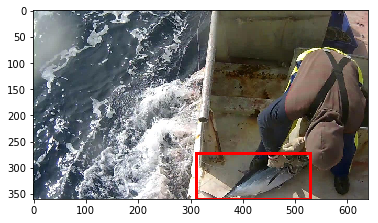

In [18]:
show_bb(0)

### Train the Multi-input Model

In [19]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [20]:
conv_val_feat = load_array(data_path + 'precomputed/val_ft_640.dat')
conv_trn_feat = load_array(data_path + 'precomputed/trn_ft_640.dat')
conv_test_feat = load_array(data_path + 'precomputed/test_ft_640.dat')

In [21]:
conv_layers, _ = split_at(vgg640, Convolution2D)

In [22]:
p = 0.6

inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [23]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [24]:
trn_labels.shape

(3277, 8)

In [25]:
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=3, verbose=2,
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
23s - loss: 26.8418 - bb_loss: 25725.5724 - class_loss: 1.1162 - bb_acc: 0.4416 - class_acc: 0.6832 - val_loss: 23.3703 - val_bb_loss: 22943.4094 - val_class_loss: 0.4269 - val_bb_acc: 0.6460 - val_class_acc: 0.9040
Epoch 2/3
22s - loss: 23.1425 - bb_loss: 22826.4024 - class_loss: 0.3161 - bb_acc: 0.5630 - class_acc: 0.9075 - val_loss: 18.7461 - val_bb_loss: 18561.5559 - val_class_loss: 0.1846 - val_bb_acc: 0.7060 - val_class_acc: 0.9540
Epoch 3/3
22s - loss: 17.4606 - bb_loss: 17264.7030 - class_loss: 0.1959 - bb_acc: 0.6970 - class_acc: 0.9457 - val_loss: 12.5144 - val_bb_loss: 12327.5211 - val_class_loss: 0.1868 - val_bb_acc: 0.7660 - val_class_acc: 0.9600


In [26]:
model.optimizer.lr = 1e-5

In [27]:
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, verbose=2,
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
22s - loss: 11.0086 - bb_loss: 10869.5308 - class_loss: 0.1391 - bb_acc: 0.7479 - class_acc: 0.9597 - val_loss: 7.5102 - val_bb_loss: 7347.8526 - val_class_loss: 0.1623 - val_bb_acc: 0.7880 - val_class_acc: 0.9660
Epoch 2/10
22s - loss: 5.7436 - bb_loss: 5613.0821 - class_loss: 0.1305 - bb_acc: 0.7757 - class_acc: 0.9576 - val_loss: 4.0182 - val_bb_loss: 3863.7507 - val_class_loss: 0.1545 - val_bb_acc: 0.8120 - val_class_acc: 0.9640
Epoch 3/10
22s - loss: 2.7268 - bb_loss: 2624.9643 - class_loss: 0.1018 - bb_acc: 0.7861 - class_acc: 0.9692 - val_loss: 2.1525 - val_bb_loss: 1983.3907 - val_class_loss: 0.1691 - val_bb_acc: 0.8220 - val_class_acc: 0.9620
Epoch 4/10
22s - loss: 1.6273 - bb_loss: 1540.6649 - class_loss: 0.0866 - bb_acc: 0.7968 - class_acc: 0.9747 - val_loss: 1.5831 - val_bb_loss: 1416.6650 - val_class_loss: 0.1665 - val_bb_acc: 0.8580 - val_class_acc: 0.9680
Epoch 5/10
21s - loss: 1.2594 - bb_loss: 1191.2244 - class_

In [28]:
pred = model.predict(conv_val_feat[0:10])

In [29]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

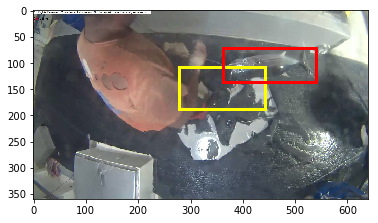

In [30]:
show_bb_pred(6)

In [31]:
model.save_weights('models/bb_multi_input/360x640/bbloss-1124.65_loss-0.25_vgg16_bn.h5')

### Submission

In [32]:
preds = model.predict(conv_test_feat, batch_size=batch_size)
preds = np.asarray([pred for pred in preds[1]])

In [33]:
preds

array([[  9.9999e-01,   2.1741e-07,   3.9265e-07, ...,   3.5851e-07,   2.0353e-07,   4.2625e-06],
       [  1.5523e-01,   2.1587e-02,   6.7581e-03, ...,   7.8645e-01,   1.7893e-02,   8.3777e-03],
       [  9.8560e-01,   1.4403e-03,   3.9437e-04, ...,   1.0828e-02,   1.8526e-04,   1.3975e-03],
       ..., 
       [  4.4800e-01,   3.4206e-04,   4.5309e-04, ...,   1.2994e-03,   1.3504e-03,   8.3685e-04],
       [  1.2990e-01,   2.9294e-04,   7.4769e-04, ...,   1.6285e-03,   1.6179e-05,   8.8600e-02],
       [  9.9965e-01,   7.5964e-06,   2.5586e-06, ...,   1.4824e-05,   3.4543e-06,   6.9930e-05]], dtype=float32)

In [34]:
def write_submission(predictions, filenames):
    preds = np.clip(predictions, clip, 1-clip)
    sub_fn = submission_path + 'bbloss-1124.65_loss-0.25_vgg16_bn'

    with open(sub_fn + '.csv', 'w') as f:
        print("Writing Predictions to CSV...")
        f.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
        for i, image_name in enumerate(filenames):
            pred = ['%.6f' % p for p in preds[i, :]]
            f.write('%s,%s\n' % (os.path.basename(image_name), ','.join(pred)))
        print("Done.")

write_submission(preds, test_filenames)

Writing Predictions to CSV...
Done.
